# ANN to model Cl

In [1]:
# Create dataset
import os
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
import torch

results_dir = "results/"
cuda0 = torch.device("cuda:0")

class AerofoilLiftSample:
    def __init__(self, file_name):
        self.file_name = file_name
        aerofoil_data = self.file_name.split("_")
        naca = aerofoil_data[1]
        self.camber = naca[0]
        self.camber_pos = naca[1]
        self.thickness = naca[2:3]
        self.reynolds = aerofoil_data[2]
        self.mach = aerofoil_data[3]
        self.alpha = aerofoil_data[4].split(".")[0]

    def __str__(self):
        return self.file_name

    def feature(self):
        return torch.tensor([[self.cp_data()["x"][:80],self.cp_data()["y"][:80]],
                            [self.cp_data()["x"][80:],self.cp_data()["y"][80:]]
                            ],
                            dtype=torch.float32, device=cuda0)
    def airfoil_params(self):
        return torch.tensor([float(self.camber),
                float(self.camber_pos),
                float(self.thickness),
                float(self.reynolds),
                float(self.mach),
                float(self.alpha)], dtype=torch.float32, device=cuda0)

    def cp_data(self):
        file = results_dir + self.file_name
        df = pd.read_csv(file, sep="\s+", skiprows=[0,1,2], names=["x", "y", "Cp"], dtype=float, on_bad_lines='skip')
        return df

    def cl(self):
        return torch.tensor(np.trapz(self.cp_data()["Cp"], self.cp_data()["x"]), dtype=torch.float, device=cuda0)

    def label(self):
        return torch.tensor([[self.cp_data()["Cp"][:80],self.cp_data()["Cp"][80:]]], dtype=torch.float, device=cuda0)

class AerofoilLiftDataset(Dataset):
    """Aerofoil Coefficient of Lift Dataset"""
    def __init__(self):
        self.samples = self.load_samples()

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        return self.samples[item].feature(), self.samples[item].airfoil_params(), self.samples[item].label()

    def load_samples(self):
        samples = []
        for file in os.listdir(results_dir):
            if "cpwr" in file:
                samples.append(AerofoilLiftSample(file))
        return samples


In [9]:
from torch.utils.data import DataLoader, random_split

dataset = AerofoilLiftDataset()

print(dataset[0][0].size())

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


train_dataLoader = DataLoader(train_dataset, batch_size=32)
test_dataLoader = DataLoader(test_dataset, batch_size=32)

torch.Size([2, 2, 80])


In [3]:
from torch.utils.tensorboard import SummaryWriter


class CNNModel(torch.nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.cnn1 = torch.nn.Conv2d(in_channels=2, out_channels=2, kernel_size=3, padding=1, device=cuda0)
        self.cnn2 = torch.nn.Conv2d(in_channels=2, out_channels=1, kernel_size=4, padding=1, device=cuda0)
        self.relu = torch.nn.ReLU()
        self.l1 = torch.nn.Linear(85, 1024, device=cuda0)
        self.l2 = torch.nn.Linear(1024, 640, device=cuda0)
        self.l3 = torch.nn.Linear(640, 79, device=cuda0)
        self.tcnn1 = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=2, padding=1, device=cuda0)

    def forward(self, pos_data, airfoil_data):
        x1 = self.cnn1(pos_data)
        c2 = self.cnn2(x1)
        x2 = torch.cat((c2.squeeze(), airfoil_data), dim=1)
        x3 = self.relu(x2)
        x4 = self.l1(x3)
        x5 = self.l2(self.relu(x4))
        x6 = self.l3(self.relu(x5))
        x7 = self.tcnn1(x6[:,None,None,:])
        return x7

model = CNNModel()
loss_fn = torch.nn.L1Loss()
optim = torch.optim.Adam(model.parameters(), lr =0.0005)


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_results(idx=4):
    df = pd.DataFrame()

    test_data = test_dataset[idx]
    test_feature, test_param, test_cp_data = test_data
    test_feature = test_feature.repeat(2,1,1,1)
    test_param = test_param.repeat(2,1)
    result = model(test_feature, test_param).cpu().detach()
    result_cp = torch.unbind(result,0)[0].squeeze().cpu().detach().tolist()
    test_cp = torch.unbind(test_cp_data, 0)[0].squeeze().cpu().detach().tolist()
    cords = torch.unbind(test_feature,0)[0].squeeze().cpu().detach().tolist()
    #print(result_cp[0], result_cp[1])
    df["Cp"] = [*result_cp[0], *result_cp[1]]
    df["x"] = [*cords[0][0], *cords[1][0]]
    df["y"] = [*cords[0][1], *cords[1][1]]
    df["valid_Cp"] = [*test_cp[0], *test_cp[1]]
    df.head(300)
    fig, ax1 = plt.subplots()
    ax1.plot(df["x"], df["Cp"], label="NN")
    ax1.plot(df["x"], df["valid_Cp"], label="XFoil")
    ax1.set_ylabel("Cp")
    ax1.set_xlabel("x")
    ax1.legend()
    cp_lim = ax1.get_ylim()
    ax1.set_ylim(cp_lim[1], cp_lim[0])
    ax2= ax1.twinx()
    ax2.plot(df["x"], df["y"], color="k")
    ax2.set_ylim(-0.4,0.4)
    ax2.axis('off')
    plt.show()



Epoch: 0


100%|██████████| 135/135 [00:32<00:00,  4.15it/s]


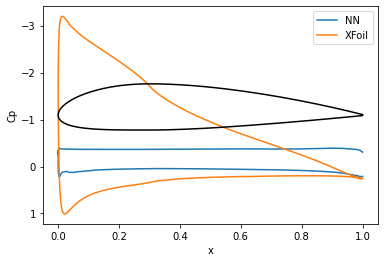

Epoch: 1


100%|██████████| 538/538 [02:13<00:00,  4.02it/s]


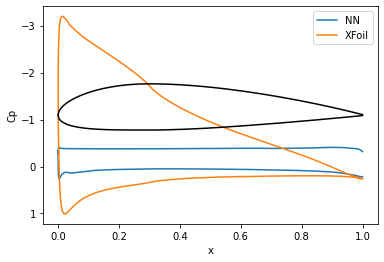

C:\Users\Sam\AppData\Local\Temp/ipykernel_6212/3093481896.py:23: RuntimeWarning: Mean of empty slice
  writer.add_scalar('validation_loss', np.nanmean(validation_loss),epoch)


Epoch: 2


 48%|████▊     | 257/538 [01:03<01:06,  4.25it/s]

In [11]:
from tqdm import tqdm
writer = SummaryWriter()
for epoch in range(500):
    print(f"Epoch: {epoch}")
    training_loss = []
    validation_loss = []
    for train_features, train_params, train_labels in tqdm(train_dataLoader):
        y_pred = model(train_features, train_params)
        loss = loss_fn(y_pred, train_labels)
        optim.zero_grad(set_to_none=True)
        loss.backward()
        optim.step()
        training_loss.append(loss.item())
    if epoch % 5 ==0:
        with torch.no_grad():
            for validation_features, validation_params, validation_labels in tqdm(test_dataLoader):
                y_pred = model(validation_features, validation_params)
                loss = loss_fn(y_pred, validation_labels)
                validation_loss.append(loss.item())
    plot_results()

    writer.add_scalar('training_loss', np.nanmean(training_loss),epoch)
    writer.add_scalar('validation_loss', np.nanmean(validation_loss),epoch)
